# Survival Models for Lung Cancer Prognosis

This notebook focuses on building and evaluating survival models to predict the survival duration of lung cancer patients based on their 3D CT scans and meta-data.

We will explore three different survival models:

- **Random Survival Forest (RSF)**.
- **Gradient Boosting (GB)**.
- **Survival Support Vector Machines (SVM)**.

The goal is to predict recurrence-free survival time. 

## Random Survival Forest.

It is an ensemble of ensemble of tree-based learners. Each individual trees are de-correlated by building each tree on a different bootstrap sample of the original training data and at each node, only evaluate the split criterion for a randomly selected subset of features and thresholds. Predictions are formed by aggregating predicitons of individuals and trees in the ensemble.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.inspection import permutation_importance

from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

set_config(display="text")  # displays text representation of estimators
sns.set_style("whitegrid")

We load the data

In [2]:
# Load the dataset.
data = pd.read_csv("../data/meta_data.csv")

X = data.drop(['PatientID', 'SurvivalTime', 'Event'], axis=1)
y = np.array([tuple(row) for row in data[['Event', 'SurvivalTime']].values], dtype=[('cens', '?'), ('time', '<f8')])

Next the data is split into 75% for training and 25% for testing. So we can determine how well our model generalizes.

In [3]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)

### Training

Several split-criterion have been proposed. The most widespread criterion is the one based on the log-rank test. 

In [4]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

In [5]:
# Check how well the model performs on the test data.
rsf.score(X_test, y_test)

0.6931818181818182

A value of 0.69 is between a moderate and good discrimination.

### Predicting

For prediction, a sample is dropped in each tree in the forest until it reaches a terminal node. This data in each terminal is used to non-parametrically estimate the survival and cumulative hazard function using the Kaplan-Meier and Nelson-Aalen estimator, respectively. Furthermore, a risk score can be computed that represents the expected number of events for one particular terminal node. 

In [6]:
# Select patients according to size of the tumor and the age of the patient.
X_test_sorted = X_test.sort_values(by=['Voxel_Volume', 'age'])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3))) # Select 3 patients with smallest and 3 with largest tumor size.

X_test_sel

,Mstage,Nstage,Tstage,age,Histology_Adenocarcinoma,Histology_LargeCell,Histology_Nos,Histology_SquamousCellCarcinoma,Compactness_2,Maximum_Diameter,Sphericity,Surface_Volume_Area,Voxel_Volume
210,0,1,4,74.0808,0,1,0,0,0.649631,13.453624,0.866075,0.651869,640.0
15,0,0,3,77.0000,0,0,0,1,0.540955,16.763055,0.814805,0.660809,738.0
124,0,0,1,67.0000,1,0,0,0,0.511728,13.674794,0.799858,0.667874,756.0
58,0,0,2,78.0000,1,0,0,0,0.207591,98.392073,0.592111,0.143646,183955.0
150,0,2,3,71.2553,0,0,0,1,0.169012,105.919781,0.552891,0.136771,261684.0
102,0,0,4,56.8214,0,0,1,0,0.162281,155.438091,0.545451,0.130889,310977.0


The risk for the last three patients is quite a bit higher than that of the first three patients.

In [7]:
pd.Series(rsf.predict(X_test_sel))

0    32.984652
1    30.420022
2    18.272664
3    50.838800
4    69.856678
5    66.420277
dtype: float64

Let's consider the predicted survival function. Put it simply, the probability of surviving after a specific time t. By visualizing the plot, we can observe that the biggest difference occurs roughly within the 600 days.

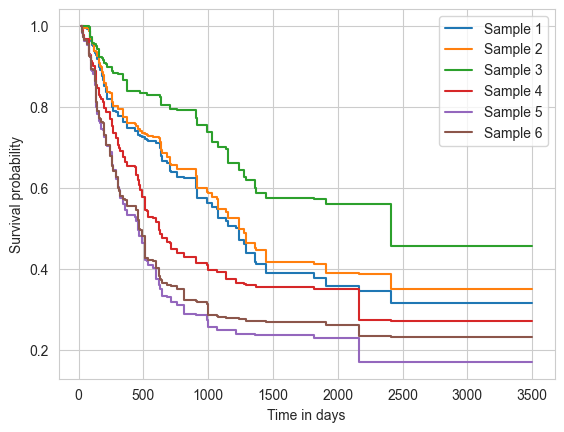

In [8]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label="Sample %d" % (i + 1))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

We can also predict the cumulative hazard function.

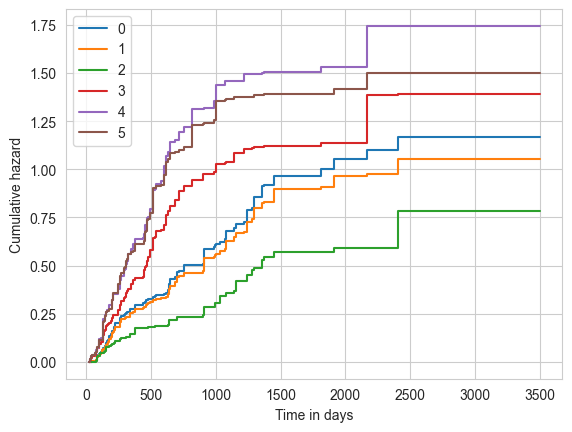

In [9]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

### Permutation-based Feature Importance

What's missing with the Random Forest is the importances of features. The way it defines 'importnace' is that it relies on the **impurity** for each child node, and defines the importance as the amount of decrease in impurity due to a split. However, for survival-analysis, there is no pre-node impurity measure due to censoring. Instead, we can use permutation to estimate feature importance, which is preferred.

In [10]:
result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=random_state)

pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
Nstage,0.020412,0.018434
Surface_Volume_Area,0.016919,0.015324
age,0.014015,0.008085
Voxel_Volume,0.009049,0.009335
Tstage,0.001263,0.002557
Mstage,0.000000,0.000000
Histology_LargeCell,-0.000715,0.000858
Histology_SquamousCellCarcinoma,-0.000842,0.001965
Histology_Nos,-0.001094,0.000963
Maximum_Diameter,-0.005177,0.013550


Result shows that patients resulting at Nstage is by far the most important feature. Meaning that if it's relationship to survival time is removed (by random shuffling), the c-index on the test data drops by an average of 0.077655 points.

## Gradient Boosted Models

Does not refer by one particular model, but a versatile framework to optimize many loss functions. Follows the strength in numbers principle by combining the predictions of multiple *base learners* to obtain a powerful overall model. Base learners are often very simple models that are slightly better than random guessing. They referred to as *weak learners*. Predictions are combined in an additive manner. The overall model *f* is an additive model of the form:

$$
f(x) = \sum_{m=1}^{M} \beta_m g(x; \theta_m)
$$

where $M > 0$ denotes the number of base learners, and $βₘ ∈ ℝ$ is a weighting term. The function *g* refers to a base learner and is parameterized by the vector *θ*. A gradient boosted model is similar to a Random Survival Forest, in the sense that it relies on multiple base learners. However, a gradient boosted model is constructed sequentially in a greedy stagewise fashion.

### Base Learners

We will use the gradient boosting survival analysis with regression tree base learners. The other possibility is to use component-wise least squares as base learners. The former is very versatile and can account for complicated non-linear relationships between features and time to survival. This is the one we will use.

### Losses

The loss function can be specified via the loss argument loss. We will use the default one: **Cox's proportional hazards model**. Therefore, the objective is to maximize the log partial likelihood function, but replacing the traditional linear model with an additive model.

$$
\arg \min _f \sum_{i=1}^n \delta_i\left[f\left(\mathbf{x}_i\right)-\log \left(\sum_{j \in \mathcal{R}_i} \exp \left(f\left(\mathbf{x}_j\right)\right)\right)\right]
$$

In [11]:
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=1000,
                                                learning_rate=1,
                                                max_depth=1,
                                                random_state=random_state)
est_cph_tree.fit(X_train, y_train)

GradientBoostingSurvivalAnalysis(learning_rate=1, max_depth=1,
                                 n_estimators=1000, random_state=20)

The prediction is moderate. The model at first sight performs worse than the Random Survival Forest.

In [12]:
est_cph_tree.score(X_test, y_test)

0.6193181818181818

Let's see how we can vary the performance of the model by varying the ensemble size (n_estimators).

In [13]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0)
for i in range(1, 31):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

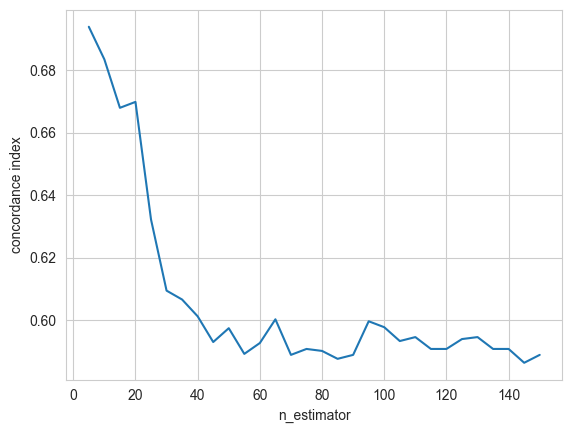

In [14]:
t, z = zip(*scores_cph_tree.items())
plt.plot(t, z)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

The performance quickly decreases whenever the ensemble gets too big.

## Survival Support Vector Machine

It is an extension to right-censored time-to-event data. The main advantage of SVM is that it can account for complex, non-linear relationships between features and survival via the kernel function. A function that maps the input features into high-dimensional features spaces where survival can be described by a hyperplane. Popular example for a kernel function is the **Radial Basis Function**

Predictions can't be easily related to standard quantities in survival analysis, namely survival function and cumulative hazard function. Furthermore, a retention of a copy of the training data is necessary in order to make predictions. Besides of the kernel function stated above, choosing a kernel function is a long process. Therefore, the Linear Survival Support Vector Machine doesn't allow to select a specific kernel function, but can be fitted faster than the more generic Kernel Survival Support Vector Machine.

### Linear Survival Support Vector Machine

Training data consists of *n* triplets $(\mathbf{x}_i, y_i, \delta_i)$, where $\mathbf{x}_i$ is a *d*-dimensional feature vector, $y_i > 0$ the survival time or time of censoring, and $\delta_i \in \{0,1\}$ the binary event indicator. Using the training data, the objective is to minimize the following function:


$$
\arg \min_{\mathbf{w},b} \frac{1}{2} \mathbf{w}^T \mathbf{w} + \frac{\alpha}{2} \left[ r \sum_{i,j \in \mathcal{P}} \max(0, 1 - (\mathbf{w}^T \mathbf{x}_i - \mathbf{w}^T \mathbf{x}_j))^2 + (1 - r) \sum_{i=0}^{n} (\zeta_{\mathbf{w},b}(y_i, \mathbf{x}_i, \delta_i))^2 \right]
$$

where

$$
\zeta_{\mathbf{w},b}(y_i, \mathbf{x}_i, \delta_i) =
\begin{cases}
\max(0, y_i - \mathbf{w}^T \mathbf{x}_i - b) & \text{if } \delta_i = 0, \\
y_i - \mathbf{w}^T \mathbf{x}_i - b & \text{if } \delta_i = 1,
\end{cases}
$$

and

$$
\mathcal{P} = \{(i,j) \mid y_i > y_j \land \delta_j = 1 \}_{i,j=1,\dots,n}
$$

The hyper-parameter $\alpha > 0$ determines the amount of regularization to apply: a smaller value increases the amount of regularization and a higher value reduces the amount of regularization. The hyper-parameter $r \in [0, 1]$ determines the trade-off between the ranking objective and the regression objective. If $r = 1$ it reduces to the ranking objective, and if $r = 0$ to the regression objective.

We are going to use the ranking objective and GridSearchCV to determine the best setting for the hyper-parameter $\alpha$.
